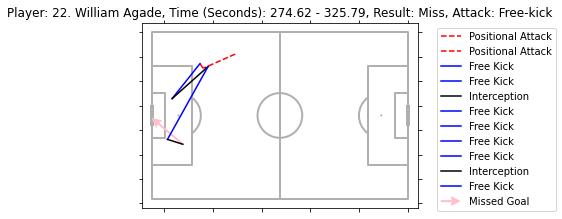

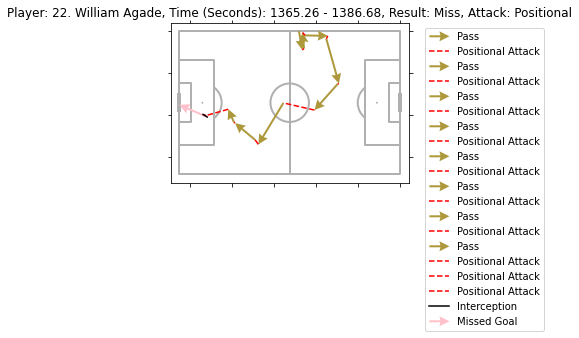

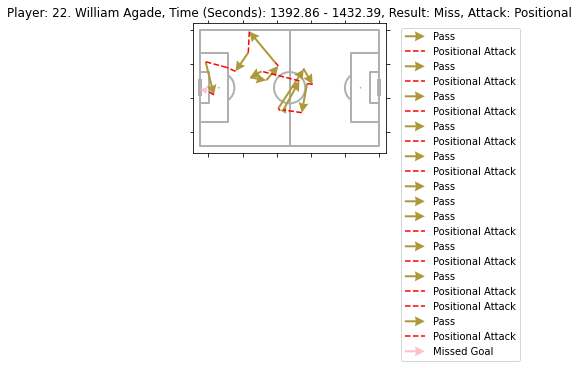

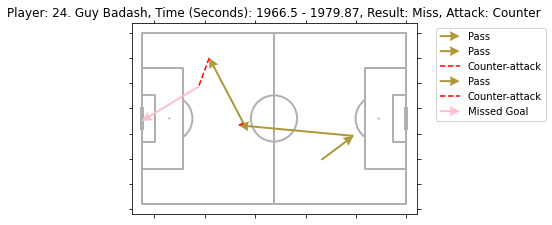

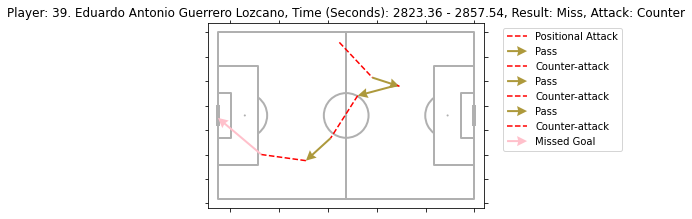

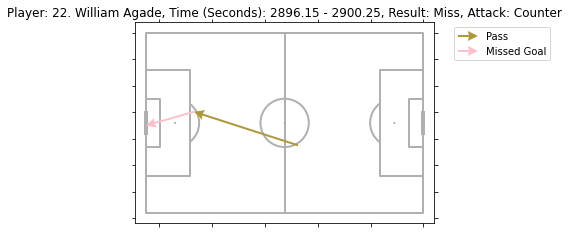

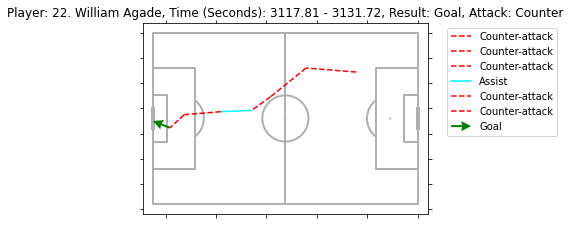

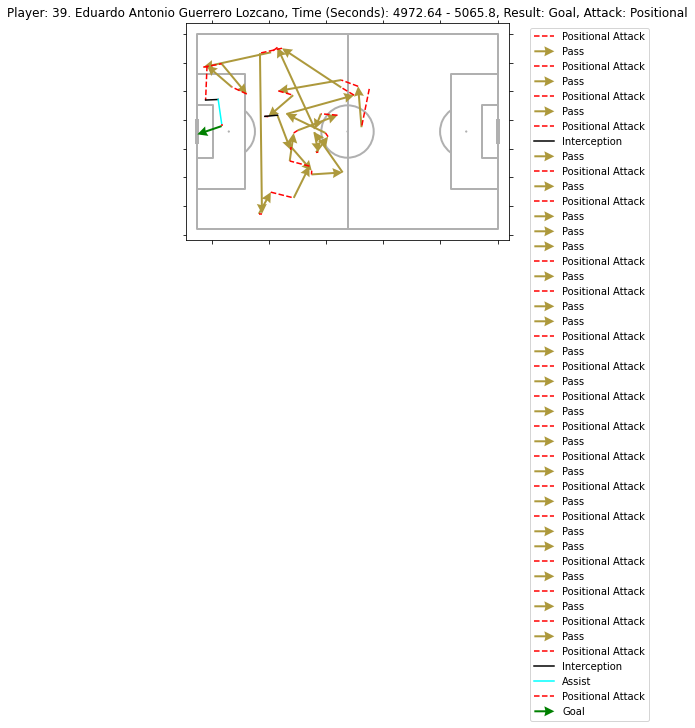

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from mplsoccer.pitch import Pitch


# Creates a dataframe from any XML file of the game data information 
# containing all the possessions ending in player shots on goal
def create_df(xml):

    # Parsing the XMl file
    tree = ET.parse(xml)
    root = tree.getroot()

    # Creating all the variables to be inserted into the dataframe 
    start = []
    end = []
    time = []
    code = []
    text = []
    posx = []
    posy = []

    # Finding all the "start" labels in the file and adding them to the array
    for inst in root.iter('start'):
        start.append(inst.text)

    # Finding all the "end" labels in the file and adding them to the array
    for inst in root.iter('end'):
        end.append(inst.text)

    # Finding all the "code" labels in the file and adding them to the array
    # "code" describes each player name and number
    for inst in root.iter('code'):
        if len(code) < len(start):
            code.append(inst.text)

    
    # Finding all the "text" labels in the file and adding them to the array
    # "text" describes each each action
    index = 0
    count = 0
    for inst in root.iter('text'):
        
        if count % 3 == 0:
            text.append(inst.text)
            count = count + 1
            index = index + 1
        else:
            text[index - 1] = text[index - 1] + " " + inst.text
            count = count + 1


    # Finding all the "code" labels in the file and adding them to the array
    # "pos_x" gives the x coordinate of the player on the pitch
    for inst in root.iter('pos_x'):
        posx.append(inst.text)


    # Finding all the "code" labels in the file and adding them to the array
    # "pos_y" gives the y coordinate of the player on the pitch
    for inst in root.iter('pos_y'):
        if len(posy) < len(start):
            posy.append(inst.text)


    # Function to determine the exact time an action occured with the given start and end times
    def calc(start, end):
        if end - start >= 20:
            return (float(end)+float(start)) / 2
        else:
            if start == 0:
                return end - 10.0
            else:
                return start + 10.0

    for i in range(len(start)):
        time.append(calc(float(start[i]), float(end[i])))
    
    # Ensuring all the arrays are the same length and eliminating unwanted data
    loc = code.index("Start")
    start.pop(loc)
    end.pop(loc)
    code.pop(loc)
    time.pop(loc)
    loc1 = code.index("Start")
    start.pop(loc1)
    end.pop(loc1)
    code.pop(loc1)
    time.pop(loc1)

    # Making the dataframe
    data = {
        'start': start,
        'end': end,
        'time': time,
        'code': code,
        'text': text,
        'posx': posx,
        'posy': posy       
    }
    df = pd.DataFrame(data,
                      columns=['start', 'end', 'time', 'code', 'text', 'posx', 'posy'])

    
    # Sorting by time to help visualize game sequences
    df = df.sort_values(by=['time'])

    # Removing rows of data that don't lead to possessions ending in shots
    df = df.loc[df['text'].str.contains('penalty') == False]
    df = df.loc[df['text'].str.contains('opp') == False]
    df = df.loc[df['text'].str.contains('Unsucc') == False]
    df = df.loc[df['text'].str.contains('Succ') == False]
    df = df.loc[df['text'].str.contains('inac') == False]
    df = df.loc[df['text'].str.contains('(won)') == False]
    df = df.loc[df['text'].str.contains('Drib') == False]
    df = df.loc[df['text'].str.contains('Picking-up') == False]
    df = df.loc[df['text'].str.contains('Goal-kick') == False]
    df = df.loc[df['text'].str.contains('passes') == False]
    df = df.loc[df['text'].str.contains('Crosses') == False]
    df = df.loc[df['text'].str.contains('Wide') == False]
    df = df.loc[df['text'].str.contains('Bad') == False]
    df = df.loc[df['text'].str.contains('conceded') == False]
    df = df.loc[df['text'].str.contains('Offside') == False]
    df = df.loc[df['text'].str.contains('Extra') == False]
    df = df.loc[df['text'].str.contains('Supers') == False]
    df = df.loc[df['text'].str.contains('(saved)') == False]
    df = df.loc[df['text'].str.contains('target') == False]
    df = df.loc[df['text'].str.contains('Error') == False]
    df = df.loc[df['text'].str.contains('post') == False] 
    
    
    
    # Removing all unnecessary opposition data since we only care about Hapoel Jerusalem
    for i in df.index:
        if (df['text'][i].split(" ")[0] + df['text'][i].split(" ")[1] != "HapoelJerusalem") and (not ('Interception' in df['text'][i])):
            df = df.drop(index=i)
    df.reset_index(drop=True, inplace=True)
    
    
    # Removing all unnecessary positional attacks 
    i = 1
    while i < df.index.array[len(df.index.array)-2]:
        if ('Positional attack' in df['text'][i] or 'Counter-attack' in df['text'][i] or "Throw-in" in df['text'][i]):
                if (df.at[i-1, 'posx'] == df.at[i, 'posx'] and df.at[i-1, 'posy'] == df.at[i, 'posy']) or (df.at[i+1, 'posx'] == df.at[i, 'posx'] and df.at[i+1, 'posy'] == df.at[i, 'posy']):
                    df = df.drop(index = i)
                    df.reset_index(drop=True, inplace=True)
                else:
                    i = i + 1
        else:
            i = i + 1


    # Removing all unnecessary interceptions
    i = 1
    while i < df.index.array[len(df.index.array)-2]:
        if ('Interception' in df['text'][i]):
                if (df.at[i-1, 'posx'] == df.at[i, 'posx'] and df.at[i-1, 'posy'] == df.at[i, 'posy']) or (df.at[i+1, 'posx'] == df.at[i, 'posx'] and df.at[i+1, 'posy'] == df.at[i, 'posy']):
                    df = df.drop(index = i)
                    df.reset_index(drop=True, inplace=True)
                else:
                    i = i + 1
        else:
            i = i + 1

    # Filtering only shots
    starti = 0
    i = 0
    lasti = 0
    while i < df.index.array[len(df.index.array)-2]: 
            if df.loc[i, 'text'].find('Lost') >= 0 or df.loc[i, 'text'].find('(lost)') >= 0 or df.loc[i, 'text'].find('Foul') >= 0 or (df['text'][i].split(" ")[0] + df['text'][i].split(" ")[1] == "HapoelJerusalem" and df.loc[i, 'text'].find('Interception') >= 0):
                df.drop(df.index[starti:i+1], inplace=True)
                i = starti
                starti = i
            elif df.loc[i, 'text'].find('Shot') >= 0 or df.loc[i, 'text'].find('Goal') >= 0:
                starti = i + 1
                i = i + 1
                lasti = i
            else:
                i = i + 1
            df.reset_index(drop=True, inplace=True)
    df.drop(df.index[lasti:len(df)],
        inplace = True)  
    df.reset_index(drop=True, inplace=True)    
                    
    return df


# Calling the function with the provided XML file 
df = create_df(
    '/Users/joshleeman/Downloads/30-04-2022--Israel--Ligat-ha-AlHapoel-Haifa-0-2-Hapoel-Jerusalem20220607-27316-1jqbd0d.xml'
)

# Coordinates of the soccer pitch
# MAX x - 105.0
# MAX y - 68.0


# Creating the pitch with the "pitch" module from matplotlib
pitch = Pitch(pitch_type='custom',
              pitch_length=105,
              pitch_width=68,
              axis=True,
              label=False,
              tick=True)
fig, ax = pitch.draw()
ax.invert_xaxis()
ax.invert_yaxis()


# Function to plot a pass as an arrow
def plot_pass(startx, starty, endx, endy):
    pitch.arrows(startx,
                 starty,
                 endx,
                 endy,
                 width=2,
                 headwidth=5,
                 headlength=5,
                 color='#ad993c',
                 ax=ax,
                 label='Pass')


# Iterating through the dataframe to plot the action
ind = 0
startx = 0.0
starty = 0.0
endx = 0.0
endy = 0.0
count = 0
pcount = 0
attack = ""
time = str(df.at[ind, 'time'])
for ind in df.index:
    if df.loc[ind, 'text'].find('Shot') >= 0:

        # Title of each graph with a missed shot
        plt.title("Player: " + df.at[ind, 'code'] + ", Time (Seconds): " + time + " - " + str(df.at[ind, 'time']) + ", Result: Miss" + ", Attack: " + attack)
        pitch.arrows(float(df.loc[ind, 'posx']),
                    float(df.loc[ind, 'posy']),
                    105,
                    35,
                    width=2,
                    headwidth=5,
                    headlength=5,
                    color='pink',
                    ax=ax,     
                    label='Missed Goal')

        # Check if we reached the end of the data
        if ind < df.index.array[len(df.index.array)-1]:

            # Create new plot for next possession
            pitch = Pitch(pitch_type='custom',
                        pitch_length=105,
                        pitch_width=68,
                        axis=True,
                        label=False,
                        tick=True)
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            fig, ax = pitch.draw()
            ax.invert_xaxis()
            ax.invert_yaxis()
        if ind < df.index.array[len(df.index.array)-1]:
            time = str(df.at[ind + 1, 'time'])
            


    elif df.loc[ind, 'text'].find('Pass') >= 0 or df.loc[ind, 'text'].find('Corner') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        plot_pass(startx, starty, endx, endy)


    elif df.loc[ind, 'text'].find('Free') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interceptions') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy], color='blue', ax=ax, label='Free Kick')
        attack = "Free-kick"

    elif df.loc[ind, 'text'].find('Interception') >= 0:

        startx = 105 - float(df.loc[ind, 'posx'])
        starty = 68 - float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy], color='black', ax=ax, label='Interception')
        
    elif df.loc[ind, 'text'].find('Positional') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy   ], color='red', linestyle='dashed', ax=ax, label = 'Positional Attack')
        attack = "Positional"

    elif df.loc[ind, 'text'].find('Throw') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy   ], color='red', linestyle='dashed', ax=ax, label='Throw-in')
        attack = "Throw"

    elif df.loc[ind, 'text'].find('Counter') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy   ], color='red', linestyle='dashed', ax=ax, label='Counter-attack')
        attack = "Counter"

    elif df.loc[ind, 'text'].find('Assists') >= 0:

        startx = float(df.loc[ind, 'posx'])
        starty = float(df.loc[ind, 'posy'])
        endx = float(df.loc[ind + 1, 'posx'])
        endy = float(df.loc[ind + 1, 'posy'])

        if (df.loc[ind + 1, 'text'].find('Interception') >= 0):
            endx = 105 - float(df.loc[ind + 1, 'posx'])
            endy = 68 - float(df.loc[ind + 1, 'posy'])

        pitch.plot([startx, endx],[starty, endy], color='aqua', ax=ax, label='Assist')


    elif df.loc[ind, 'text'].find('Goal') >= 0:

        # Title of each graph with a goal
        plt.title("Player: " + df.at[ind, 'code'] + ", Time (Seconds): " + time + " - "  + str(df.at[ind, 'time']) + ", Result: Goal" + ", Attack: " + attack)

        pitch.arrows(float(df.loc[ind, 'posx']),
                    float(df.loc[ind, 'posy']),
                    105,
                    35,
                    width=2,
                    headwidth=5,
                    headlength=5,
                    color='green',
                    ax=ax,     
                    label='Goal')

        # Create new plot for next possession
        pitch = Pitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                axis=True,
                label=False,
                tick=True)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        # Check if we reached the end of the data
        if ind < df.index.array[len(df.index.array)-1]:
            fig, ax = pitch.draw()
            ax.invert_xaxis()
            ax.invert_yaxis()
            count = count + 1

        if ind < df.index.array[len(df.index.array)-1]:
            time = str(df.at[ind + 1, 'time'])